In [ ]:
# @title Type II NeuroFuzzy
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split

def get_Normalized_data(file_path):
    url = 'https://drive.google.com/uc?id=' + file_path.split('/')[-2]
    output = 'Temperature_Dataset.xlsx'
    gdown.download(url, output, quiet=False)
    data = pd.read_excel(output)
    # Perform min-max normalization on column 'A'
    min_value = data['A'].min()
    max_value = data['A'].max()

    data['B'] = (data['A'] - min_value) / (max_value - min_value)

    # Create new columns for the next two time steps
    data['C'] = data['B'].shift(-1)
    data['Target'] = data['B'].shift(-2)
    # Drop the rows with missing values(last 2 rows)
    data = data.dropna()
    X = data[['B', 'C']].values  # Inputs
    y = data[['Target']].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle = False)
    return data, X_train, X_test, y_train, y_test


class Mamdani_NeuroFuzzyTypeI:
    def __init__(self, file_path, numberOfMembershipFunctionInput = 7, productMFs = [], productArray = None):
        self.numberOfMembershipFunctionInput = numberOfMembershipFunctionInput
        #self.data = self.get_Normalized_data()
        self.data, self.X_train, self.X_test, self.y_train, self.y_test = get_Normalized_data(file_path)
        self.productMFs = productMFs
        self.productArray = np.array([])

    # Define parameters for membership functions
    def get_parameters_MFs(self, numberOfMFs, maxValue): #Main(UpperBound)  MFs parameters
        step=maxValue/(numberOfMFs-1)
        parameters_MFs=[]
        for i in range(numberOfMFs):
           if(i==0):
              index=[0,0,1*step]
           elif(i==numberOfMFs-1):
              index=[(i-1)*step, i*step, i*step]
           else:
              index=[(i-1)*step, i*step, (i+1)*step]
           parameters_MFs.append(index)

        return  parameters_MFs

    def get_lowerBound_parameters_MFs(self, numberOfMFs, maxValue): #Lowerbound MFs parameters
        step=maxValue/(numberOfMFs-1)
        lowerBound_parameters_MFs=[]
        for i in range(numberOfMFs):
           if(i==0):
              index=[0,0,1*step - (step/3)]
           elif(i==numberOfMFs-1):
              index=[(i-1)*step + (step/3), i*step, i*step]
           else:
              index=[(i-1)*step + (step/3), i*step, (i+1)*step - (step/3)]
           lowerBound_parameters_MFs.append(index)

        return  lowerBound_parameters_MFs

    # Define membership functions
    def triangular(self, x, listParameters):
        a, b, c = listParameters[0],listParameters[1],listParameters[2]
        if a < x < b:
            if b - a == 0: # to ensure that division by zero does not occur
              return 0.0

            return (x - a) / (b - a)

        elif b <= x <= c:
            if c - b == 0: # to ensure that division by zero does not occur
              return 0.0

            return (c - x) / (c - b)

        else:
            return 0.0

    def product_MFs_Inputs(self,input1, input2):
        parameters_MFs_OneDayBefore=self.get_parameters_MFs(numberOfMembershipFunctionInput,1)
        parameters_MFs_TwoDaysBefore=self.get_parameters_MFs(numberOfMembershipFunctionInput,1)
        lowerBound_parameters_MFs_OneDayBefore=self.get_lowerBound_parameters_MFs(numberOfMembershipFunctionInput,1)
        lowerBound_parameters_MFs_TwoDaysBefore=self.get_lowerBound_parameters_MFs(numberOfMembershipFunctionInput,1)
        for i in range(numberOfMembershipFunctionInput*numberOfMembershipFunctionInput):
           listParameters1 = parameters_MFs_OneDayBefore[self.data.iloc[i, 4]-1]
           listParameters2 = parameters_MFs_TwoDaysBefore[self.data.iloc[i, 5]-1]
           listParameters3 = lowerBound_parameters_MFs_OneDayBefore[self.data.iloc[i, 4]-1] #for Lowerbound parameters of input1
           listParameters4 = lowerBound_parameters_MFs_TwoDaysBefore[self.data.iloc[i, 5]-1]#for Lowerbound parameters of input2
           MF_value1 = self.triangular(input1,listParameters1)#calculating MFs value for Upperbound parameters of input1
           MF_value2 = self.triangular(input2,listParameters2)#calculating MFs value for Upperbound parameters of input2
           MF_value3 = self.triangular(input1,listParameters3)#calculating MFs value for Lowerbound parameters of input1
           MF_value4 = self.triangular(input2,listParameters4)#calculating MFs value for Lowerbound parameters of input2
           product = (MF_value1 * MF_value2 + MF_value3 * MF_value4)/2 #Multiplying four MF values and dividing them by 2
           self.productMFs.append(product)
           if i == numberOfMembershipFunctionInput*numberOfMembershipFunctionInput - 1:
              self.productArray = np.array(self.productMFs)
              self.productMFs.clear()

        return

    def get_rules_table(self):
        return self.data

numberOfMembershipFunctionInput=7

# Create an instance of Mamdani_NeuroFuzzyTypeI
fis = Mamdani_NeuroFuzzyTypeI('https://docs.google.com/spreadsheets/d/16p977TTYGyVpRcdFwSj-MtHiO8isqZdP/edit?usp=drive_link')
fis.get_rules_table()


Downloading...
From: https://drive.google.com/uc?id=16p977TTYGyVpRcdFwSj-MtHiO8isqZdP
To: /content/Temperature_Dataset.xlsx
100%|██████████| 17.5k/17.5k [00:00<00:00, 14.1MB/s]


,A,B,C,Prediction,x1,x2,Target
0,6.2,0.202020,0.242424,0,1,1,0.272727
1,7.8,0.242424,0.272727,0,1,2,0.388889
2,9.0,0.272727,0.388889,0,1,3,0.333333
3,13.6,0.388889,0.333333,0,1,4,0.247475
4,11.4,0.333333,0.247475,0,1,5,0.196970
...,...,...,...,...,...,...,...
328,10.6,0.313131,0.282828,0,0,0,0.262626
329,9.4,0.282828,0.262626,0,0,0,0.242424
330,8.6,0.262626,0.242424,0,0,0,0.242424
331,7.8,0.242424,0.242424,0,0,0,0.227273


Downloading...
From: https://drive.google.com/uc?id=16p977TTYGyVpRcdFwSj-MtHiO8isqZdP
To: /content/Temperature_Dataset.xlsx
100%|██████████| 17.5k/17.5k [00:00<00:00, 28.2MB/s]


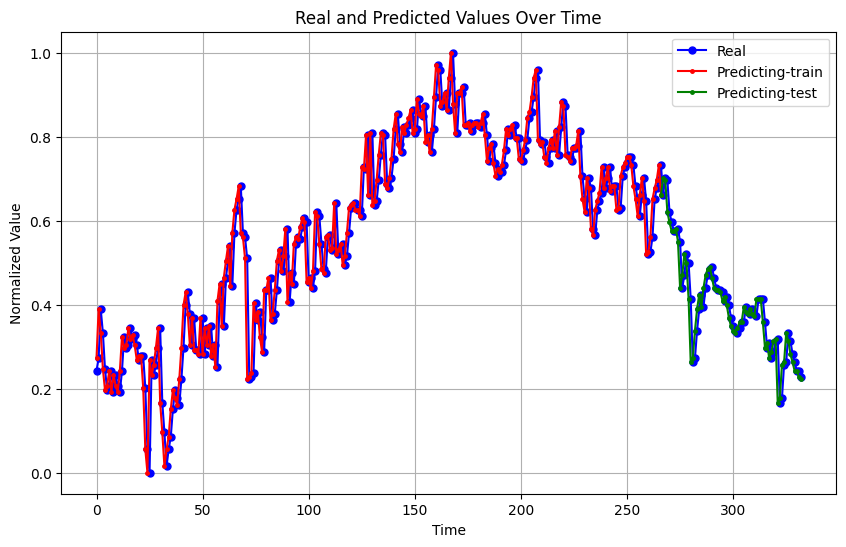

In [ ]:
# @title Type II NeuroFuzzy
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def get_Normalized_data(file_path):
    url = 'https://drive.google.com/uc?id=' + file_path.split('/')[-2]
    output = 'Temperature_Dataset.xlsx'
    gdown.download(url, output, quiet=False)
    data = pd.read_excel(output)
    # Perform min-max normalization on column 'A'
    min_value = data['A'].min()
    max_value = data['A'].max()

    data['B'] = (data['A'] - min_value) / (max_value - min_value)

    # Create new columns for the next two time steps
    data['C'] = data['B'].shift(-1)  # 'Real' values
    data['Target'] = data['B'].shift(-2)  # 'Predict' values
    # Drop the rows with missing values (last 2 rows)
    data = data.dropna()
    X = data[['B', 'C']].values  # Inputs
    y = data[['Target']].values  # Outputs
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=False)
    return data, X_train, X_test, y_train, y_test

class Mamdani_NeuroFuzzyTypeI:
    def __init__(self, file_path, numberOfMembershipFunctionInput=7, productMFs=[], productArray=None):
        self.numberOfMembershipFunctionInput = numberOfMembershipFunctionInput
        self.data, self.X_train, self.X_test, self.y_train, self.y_test = get_Normalized_data(file_path)
        self.productMFs = productMFs
        self.productArray = np.array([])

    def get_parameters_MFs(self, numberOfMFs, maxValue):  # Main(UpperBound) MFs parameters
        step = maxValue / (numberOfMFs - 1)
        parameters_MFs = []
        for i in range(numberOfMFs):
            if i == 0:
                index = [0, 0, 1*step]
            elif i == numberOfMFs - 1:
                index = [(i-1)*step, i*step, i*step]
            else:
                index = [(i-1)*step, i*step, (i+1)*step]
            parameters_MFs.append(index)
        return parameters_MFs

    def get_lowerBound_parameters_MFs(self, numberOfMFs, maxValue):  # Lowerbound MFs parameters
        step = maxValue / (numberOfMFs - 1)
        lowerBound_parameters_MFs = []
        for i in range(numberOfMFs):
            if i == 0:
                index = [0, 0, 1*step - (step / 3)]
            elif i == numberOfMFs - 1:
                index = [(i-1)*step + (step / 3), i*step, i*step]
            else:
                index = [(i-1)*step + (step / 3), i*step, (i+1)*step - (step / 3)]
            lowerBound_parameters_MFs.append(index)
        return lowerBound_parameters_MFs

    def triangular(self, x, listParameters):
        a, b, c = listParameters
        if a < x < b:
            return (x - a) / (b - a)
        elif b <= x <= c:
            return (c - x) / (c - b)
        else:
            return 0.0

    def product_MFs_Inputs(self, input1, input2):
        parameters_MFs_OneDayBefore = self.get_parameters_MFs(self.numberOfMembershipFunctionInput, 1)
        parameters_MFs_TwoDaysBefore = self.get_parameters_MFs(self.numberOfMembershipFunctionInput, 1)
        lowerBound_parameters_MFs_OneDayBefore = self.get_lowerBound_parameters_MFs(self.numberOfMembershipFunctionInput, 1)
        lowerBound_parameters_MFs_TwoDaysBefore = self.get_lowerBound_parameters_MFs(self.numberOfMembershipFunctionInput, 1)
        for i in range(self.numberOfMembershipFunctionInput * self.numberOfMembershipFunctionInput):
            listParameters1 = parameters_MFs_OneDayBefore[self.data.iloc[i, 4]-1]
            listParameters2 = parameters_MFs_TwoDaysBefore[self.data.iloc[i, 5]-1]
            listParameters3 = lowerBound_parameters_MFs_OneDayBefore[self.data.iloc[i, 4]-1]
            listParameters4 = lowerBound_parameters_MFs_TwoDaysBefore[self.data.iloc[i, 5]-1]
            MF_value1 = self.triangular(input1, listParameters1)
            MF_value2 = self.triangular(input2, listParameters2)
            MF_value3 = self.triangular(input1, listParameters3)
            MF_value4 = self.triangular(input2, listParameters4)
            product = (MF_value1 * MF_value2 + MF_value3 * MF_value4) / 2
            self.productMFs.append(product)
            if i == self.numberOfMembershipFunctionInput * self.numberOfMembershipFunctionInput - 1:
                self.productArray = np.array(self.productMFs)
                self.productMFs.clear()

    def get_rules_table(self):
        return self.data

numberOfMembershipFunctionInput = 7

# Create an instance of Mamdani_NeuroFuzzyTypeI
fis = Mamdani_NeuroFuzzyTypeI('https://docs.google.com/spreadsheets/d/16p977TTYGyVpRcdFwSj-MtHiO8isqZdP/edit?usp=drive_link')
fis.get_rules_table()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fis.data['C'], label='Real', linestyle='-', marker='o', color='blue', markerfacecolor='blue', markersize=5)
plt.plot(fis.data.loc[:int(len(fis.data)*0.8), 'Target'], label='Predicting-train', linestyle='-', marker='.', color='red', markerfacecolor='red', markersize=5)
plt.plot(fis.data.loc[int(len(fis.data)*0.8):, 'Target'], label='Predicting-test', linestyle='-', marker='.', color='green', markerfacecolor='green', markersize=5)
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.title('Real and Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-11-432d8025bb11>:113: RuntimeWarning: invalid value encountered in scalar divide
  return (c - x) / (c - b)


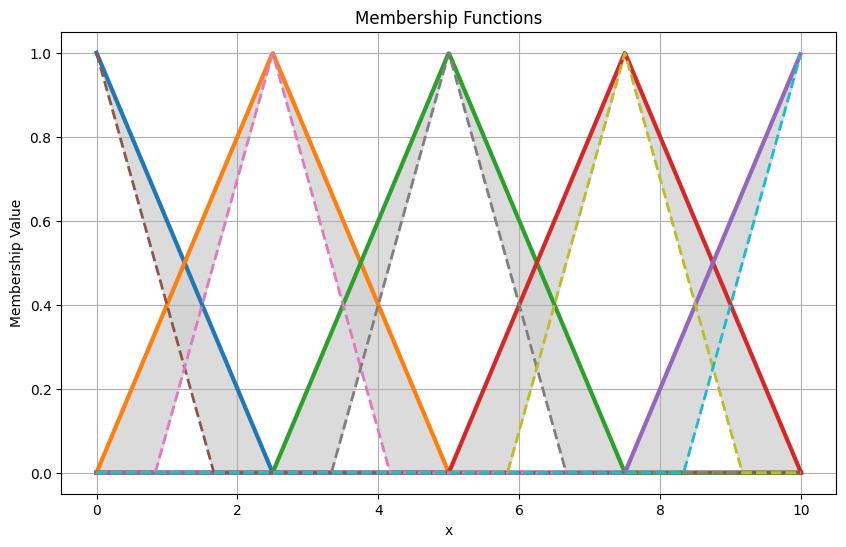

Downloading...
From: https://drive.google.com/uc?id=16p977TTYGyVpRcdFwSj-MtHiO8isqZdP
To: /content/Temperature_Dataset.xlsx
100%|██████████| 17.5k/17.5k [00:00<00:00, 29.9MB/s]


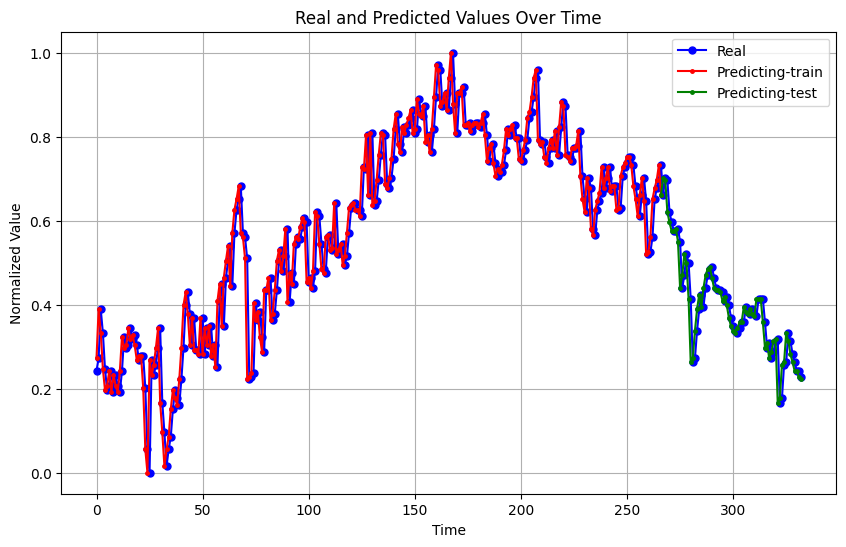

In [ ]:
# @title Type II NeuroFuzzy
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to normalize data and prepare for training/testing
def get_Normalized_data(file_path):
    url = 'https://drive.google.com/uc?id=' + file_path.split('/')[-2]
    output = 'Temperature_Dataset.xlsx'
    gdown.download(url, output, quiet=False)
    data = pd.read_excel(output)
    # Perform min-max normalization on column 'A'
    min_value = data['A'].min()
    max_value = data['A'].max()

    data['B'] = (data['A'] - min_value) / (max_value - min_value)

    # Create new columns for the next two time steps
    data['C'] = data['B'].shift(-1)  # 'Real' values
    data['Target'] = data['B'].shift(-2)  # 'Predict' values
    # Drop the rows with missing values (last 2 rows)
    data = data.dropna()
    X = data[['B', 'C']].values  # Inputs
    y = data[['Target']].values  # Outputs
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=False)
    return data, X_train, X_test, y_train, y_test

# Main class for the NeuroFuzzy Type I system
class Mamdani_NeuroFuzzyTypeI:
    def __init__(self, file_path, numberOfMembershipFunctionInput=7, productMFs=[], productArray=None):
        self.numberOfMembershipFunctionInput = numberOfMembershipFunctionInput
        self.data, self.X_train, self.X_test, self.y_train, self.y_test = get_Normalized_data(file_path)
        self.productMFs = productMFs
        self.productArray = np.array([])

    def triangular(self, x, listParameters):
        a, b, c = listParameters
        if a < x < b:
            return (x - a) / (b - a)
        elif b <= x <= c:
            return (c - x) / (c - b)
        else:
            return 0.0

    # This was missing earlier, now defined to simply return the data
    def get_rules_table(self):
        return self.data

# Setup and plot membership functions
class MembershipFunctionsPlotter:
    def __init__(self, numberOfMFs, maxValue):
        self.numberOfMFs = numberOfMFs
        self.maxValue = maxValue

    def get_parameters_MFs(self):
        step = self.maxValue / (self.numberOfMFs - 1)
        parameters_MFs = []
        for i in range(self.numberOfMFs):
            if i == 0:
                index = [0, 0, 1 * step]
            elif i == self.numberOfMFs - 1:
                index = [(i - 1) * step, i * step, i * step]
            else:
                index = [(i - 1) * step, i * step, (i + 1) * step]
            parameters_MFs.append(index)
        return parameters_MFs

    def get_lowerBound_parameters_MFs(self):
        step = self.maxValue / (self.numberOfMFs - 1)
        lowerBound_parameters_MFs = []
        for i in range(self.numberOfMFs):
            if i == 0:
                index = [0, 0, 1 * step - (step / 3)]
            elif i == self.numberOfMFs - 1:
                index = [(i - 1) * step + (step / 3), i * step, i * step]
            else:
                index = [(i - 1) * step + (step / 3), i * step, (i + 1) * step - (step / 3)]
            lowerBound_parameters_MFs.append(index)
        return lowerBound_parameters_MFs

    def plot_membership_functions(self):
        x = np.linspace(0, self.maxValue, 1000)
        parameters_MFs = self.get_parameters_MFs()
        lowerBound_parameters_MFs = self.get_lowerBound_parameters_MFs()

        plt.figure(figsize=(10, 6))
        for params in parameters_MFs:
            y = [self.triangular_membership(x_i, params) for x_i in x]
            plt.plot(x, y, linewidth=3)

        for params in lowerBound_parameters_MFs:
            y = [self.triangular_membership(x_i, params) for x_i in x]
            plt.plot(x, y, '--', linewidth=2)

        for params_main, params_lower in zip(parameters_MFs, lowerBound_parameters_MFs):
            y_main = np.array([self.triangular_membership(x_i, params_main) for x_i in x])
            y_lower = np.array([self.triangular_membership(x_i, params_lower) for x_i in x])
            plt.fill_between(x, y_main, y_lower, color='lightgray', alpha=0.8)

        plt.xlabel('x')
        plt.ylabel('Membership Value')
        plt.title('Membership Functions')
        plt.grid(True)
        plt.show()

    def triangular_membership(self, x, listParameters):
        a, b, c = listParameters
        if a < x < b:
            return (x - a) / (b - a)
        elif b <= x <= c:
            return (c - x) / (c - b)
        else:
            return 0.0

# Example usage to plot membership functions
numberOfMFs = 5
maxValue = 10

plotter = MembershipFunctionsPlotter(numberOfMFs, maxValue)
plotter.plot_membership_functions()

# Create an instance of Mamdani_NeuroFuzzyTypeI
fis = Mamdani_NeuroFuzzyTypeI('https://docs.google.com/spreadsheets/d/16p977TTYGyVpRcdFwSj-MtHiO8isqZdP/edit?usp=drive_link')
fis.get_rules_table()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fis.data['C'], label='Real', linestyle='-', marker='o', color='blue', markerfacecolor='blue', markersize=5)
plt.plot(fis.data.loc[:int(len(fis.data)*0.8), 'Target'], label='Predicting-train', linestyle='-', marker='.', color='red', markerfacecolor='red', markersize=5)
plt.plot(fis.data.loc[int(len(fis.data)*0.8):, 'Target'], label='Predicting-test', linestyle='-', marker='.', color='green', markerfacecolor='green', markersize=5)
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.title('Real and Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.show()


perceptron

In [ ]:
# @title Prediction
import matplotlib.pyplot as plt

# Set display options to show all rows and columns
#pd.set_option('display.max_rows', None)  # None means unlimited rows
#pd.set_option('display.max_columns', None)  # None means unlimited columns

class Perceptron:
    def __init__(self, product_matrix_of_MFs):
        self.product_matrix_of_MFs = product_matrix_of_MFs
        self.weights = np.random.rand(product_matrix_of_MFs)
        self.bias = np.random.rand()

    def feedforward(self, inputs):
        return np.dot(inputs, self.weights) + self.bias

    def train(self, inputs, target, learning_rate=0.1):
        output = self.feedforward(inputs)
        error = target - output
        self.weights += learning_rate * error * inputs
        self.bias += learning_rate * error
        return error

    def predict(self, inputs):
        return self.feedforward(inputs)

    def product_inputs_with_ws(self, inputs):
        return np.dot(inputs, self.weights)

    def model_test(self ,inputs):
        return self.product_inputs_with_ws(inputs)


# Initialize the perceptron
product_matrix_of_MFs = numberOfMembershipFunctionInput * numberOfMembershipFunctionInput
perceptron = Perceptron(product_matrix_of_MFs)

# Initialize lists to store error and epochs
errors = []
epochs = []

# Set number of epochs
num_epochs = 20

# Train the perceptron using NeuroFuzzy system's product array as inputs and target values
#X_train_of_matrix = fis.productArray.reshape(-1, product_matrix_of_MFs)  # Reshape to match input size

#y_train = 0.2727 #fis.data['Target'].values


# Train the perceptron using NeuroFuzzy system's product array as inputs and target values for multiple epochs
def update_Weights():
    for epoch in range(num_epochs):
        total_error = 0
        for i in range(len(X_train_of_matrix)):
            error = perceptron.train(X_train_of_matrix[i], y_train)
            total_error += abs(error)  # Calculate total error for the epoch
        errors.append(total_error / len(X_train_of_matrix))  # Average error per data point
        epochs.append(epoch)

#update_Weights()
#fis.data['Prediction'] = 0

# Train all rows of X_train of Dataset
for i in range(len(fis.X_train)):
        fis.product_MFs_Inputs(fis.X_train[i,0] ,fis.X_train[i,1]) # Gets B and C columns of Dataset as inputs for calculate MFs product
        X_train_of_matrix = fis.productArray.reshape(-1, product_matrix_of_MFs)
        y_train = fis.y_train[i]
        update_Weights()
        input_sample = np.array(fis.productArray)  # Example input
        prediction = perceptron.predict(input_sample)
        #print("i=",i,"Prediction:", prediction)
        #fis.data.iloc[i,3] = 5
        fis.data.at[i, 'Prediction'] = prediction
      #print("i=", i,"target",type(y_train))

excelData = fis.get_rules_table()
print(excelData)

predictions_test = []
for i in range(len(fis.X_test)):
    fis.product_MFs_Inputs(fis.X_test[i,0], fis.X_test[i,1])
    X_test_of_matrix = fis.productArray.reshape(-1, product_matrix_of_MFs)
    testing_prediction = perceptron.model_test(X_test_of_matrix[0])
    predictions_test.append(testing_prediction)
    #test_input_sample = np.array(fis.productArray)  # Example input
    #predictionTest = perceptron.predict(test_input_sample)
    #print(testing_prediction)
    fis.data.at[i+len(fis.X_train), 'Prediction'] = testing_prediction#predictionTest


mse_test = np.mean((np.array(predictions_test) - fis.y_test) ** 2)
rmse_test = np.sqrt(mse_test)
print("Mean Squared Error (MSE) on test data:", mse_test)
print("Root Mean Squared Error (RMSE) on test data:", rmse_test)




# Plot error versus epochs
plt.plot(epochs, errors)
plt.xlabel('Epochs')
plt.ylabel('Average Error')
plt.title('Training Progress')
plt.grid(True)
plt.show()

# Make predictions using the trained perceptron
#input_sample = np.array(fis.productArray)  # Example input
#prediction = perceptron.predict(input_sample)
#print("Prediction:", prediction)

